# Titanic Survival Prediction: 01 - Initial data exploration
*Date: 2025-06-25*
*Author: Jonas Lilletvedt*

--- 

## 1. Objective

In this notebook we will perform an initial exploratory data analysis (EDA) on the training data. We want to:
*   Understand the data structure, variables, and statistical properties of the data set.
*   Identify and quantify data quality problems, this includes NANs, outliers and nonrational values.
*   Construct a clear path for the data cleaning and feature engineering for the following notebooks.

## 2. Data source

The data used in this notebook is the 'train.csc' file from the [Kaggle "Titanic - Machine Learning from the Disaster" competition] (https://www.kaggle.com/competitions/titanic).

## 3. Plan for the initial inspection

We will proceed in the following steps:
1.  **Setup** Import necessary libraries and load the raw data.
2.  **Initial inspection** A high level overview using built in functions from pandas, like `.info()`, `.head()` and `.describe()`.
3.  **Data visualization (EDA):**
    *   Analyze the target variable (`Survived`).
    *   Analyze the individual features (Univariate analysis).
    *   Analyze the relationship between features and the target (Bivariate analysis).
4. **Summary and Next steps:** Document key findings and define a clear plan for further notebooks.


## 1: Setup and loading

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [101]:
# Load the data
df_train = pd.read_csv('../data/01_raw/train.csv')

# Show the five first rows
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2: Initial Data Inspection

We will start with a high-level overview of the training data, to understand its structure, and identify quality issues, and review basic statistics.

### 2.1 Data structure and Null values (`.info()`)

We will first use `.info()` method to get a short summary of the training dataset. This will show us column names and types. As well as the count of missing values for each column.

In [102]:
# Display data types and missing value counts for the columns
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Observations from `.info()`:**

An initial review of the 891 entries using `.info()` reveals tree columns with data quality issues that requires cleaning.

--- 

**`Age` (Numeric)**
*   **Issue**: 177 missing values.
*   **Possible strategy**: **Impute with median** as a baseline. We will explore if more complex methods would provide a better result during model iteration.

**`Cabin` (Categorical)**
*   **Issue**: Severe data loss, missing 687 values (over 77% missing).
*   **Possible strategy**: Impute using k-nearest neighbors, or drop the whole column if it does not provide any value additional value to prediction of target. `PClass` has could be a good plausible indicator for cabin.

**`Embarked` (Categorical)**
*   **Issue**: Two missing values.
*   **Possible strategy**: **Impute with mode**.

### 2.2 Statistical Summary for Numerical and Categorical Features (`.describe()` and `.describe(include=[`object`]))

Next step is to examine descriptive statistics for numerical and categorical columns.

In [103]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Observations from Numerical Feature summary (`.describe()`)**

A statistical summary of numerical variables in the dataset.

---

*   **Survival rate** The mean of `Survived` column is 0.38, with no missing values. 38% of passengers in the training data survived.
*   **Fare Outliers** The 75% quantile is severely lower than the max `Fare` value, 31$ compared to 512$. This indicates strong outliers that we will need to handle, possibly with an imputation technique.



In [104]:
df_train.describe(include=['object'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,G6,S
freq,1,577,7,4,644


**Observations from Categorical Feature summary (`.describe(include=['object'])`)**

A summary of categorical variables reveals key insights that dictates our feature engineering strategy.

--- 

*   **`Name`**
    *   **Observation**: As expected `Name` has a **high cardinality** with all 891 entries being unique. In its raw form, the feature is unsuitable for direct use as it would likely only introduce noise.
    *   **Hypothesis**: Despite its high cardinality, the `Name` feature is rich with implicit information. Many of the names are prefixed with a title like *Mrs*, *Mr* or *Dr*. These titles indicates sex, age if no title, marriage and economic and socioeconomic status. Last but not least the surname could be used to indicate family members. There is a large possibility that family members stick together during crisis.
        *   **Titles**: Prefixed like *Mr.*, *Miss.*, *Mrs.* and *Master.* are strong proxies for sex, age and marital status. Other titles like *Dr.* or *Rev* can indicate socioeconomic status and profession.
        *   **Surname**: The surname can be used to identify potential family members groups that might not be fully captured by `SibSp` and `Parch` features. It's hypothesized that family members may have had survival outcomes due to staying together. 
    *   **Strategy**: Engineer two new features by decomposing the `Name` column.
        *   `Title_feat`: A categorical feature extracted from the name prefix. To prevent possible over-fitting and noise rare titles will be consolidated into a single 'Rare' category.
        *   `FamilySurvivalRate_feat`: A numerical feature representing the survival rate of a passengers's family unit. 
            *   **Family Identification**: A robust Family_ID will be created by combining the passenger's `Surname_feat` and `TicketPrefix_feat`. This approach helps prevent misidentifying different families with the same surname, but traveling with a different ticket type. 
            *   **Leakage Proof calculation**: To avoid data leakage, the survival rate will be calculated for each passenger's family excluding the passenger themselves.
            *   **Imputation for solo travelers**: For passengers with no identifiable family members. this feature will be imputed with the overall survival rate of the entire dataset.

*   **Sex distribution**
    *   **Observation***: The dataset is imbalanced, containing **577 males (65%) and 314 females (35%)**.
    *   **Hypothesis**: Due to females having a higher rescue priority, `Sex` will be a primary indicator of `Survived`. We will validate this with visualizations. 

*   **`Ticket`**
    *   **Issue**: The column has a very **high cardinality** (681 unique values). Making the raw feature unsuitable for direct use.
    *   **Hypothesis**: Passengers with closely related ticket-numbers might travel together or have other properties that could predict survival rate.
    *   **Strategy**: We will engineer new features based on the `Ticket` string and validate them against `Survived`:
        *   `TicketGroupSize_feat`: A numerical feature counting passengers on the same ticket.
        *   `TicketPrefix_feat` A categorical feature for any text-based prefix (indicating economical class).

*   **`Cabin`**
    *   **Issue**: In addition to ~77% missing values, the column has a high cardinality. This proposes the same obstacle as for `Ticket`.
    *   **Hypothesis**: A passenger's physical cabin location on  the ship, encoded in `Cabin` string, is a strong predictor for survival.
    *   **Strategy**: Deconstruct the `Cabin` string into vertical and horizontal location:
        *   `CabinPrefix_feat`: A categorical feature for any text based-prefix (the deck, vertical location).
        *   `CabinZone_feat`: A categorical feature from binned cabin numbers. Representing the horizontal location on the deck.

## 3: Data Visualization (EDA)

--- 

In this section we will analyze the target variable `Survived`, and test our hypothesis made in the *Initial Data Inspection*. We will also take a more general look at other features using univariate and bivariate analysis.

### 3.1 Analysis of the Target Variable `Survived`

---
As a baseline for the rest of the analysis, we will now visualize the target `variable`. With this approach we get a overview on the most crucial part of the project. How does our target variable behave?


To start we will use a `countplot` to get a simple overview of the distribution of our target variable.

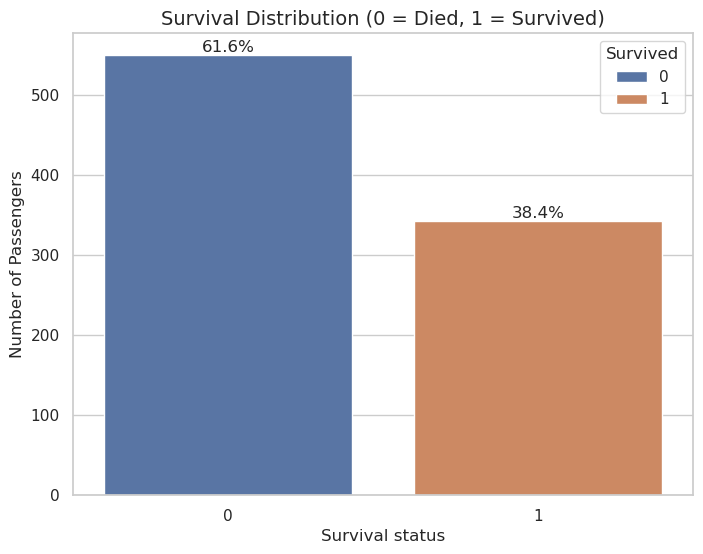

In [105]:
# A general config for all plots in the notebook --> To insure a consistent style
sns.set_theme(style='whitegrid')

# Create countplot for `Survived`
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_train, x='Survived', hue='Survived')
plt.title('Survival Distribution (0 = Died, 1 = Survived)', fontsize=14)
plt.xlabel('Survival status', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)

# Add percentage bars on top for clarity
total =  len(df_train)
count = 0
for p in ax.patches:
    if p.get_height() > 0:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

# Show the final plot
plt.show()

**Observations from Countplot for `Survived` (`sns.countplot()`)**

---

A simple and direct plot for visualization of categorical variables.

*   **Imbalanced survival distribution**
    *   **Observation**: The plot confirms the classes are imbalanced. 38.4% percent of all passengers survive. Thus 61.6% do not.
    *   **Implication for modeling**: This imbalance is a crucial baseline. A naive model only predicting "Died" would have an accuracy of 61.6%. Therefore for our model to be useful it need to perform notably better then this baseline. 
    
    *   Furthermore, this imbalance means that accuracy alone is an insufficient metric. A superior assessment strategy would be to evaluate the model's performance on both "Died" and "Survived" classes separately. For this approach we will evaluate our models performance using **Precision**, **F1-score** and **Recall**. 

## 3.2 Univariate Analysis

--- 

In this section we will explore and analyze each predictor feature individually to understand its distribution and characteristics. This will help us identify possible outliers and skewness, we need to be aware of during the feature engineering process and modeling.

To start we will define our predictive features. We will exclude `Survived` due to it being the target variable, as well as `PassengerId` as it holds no predictive value.

In [ ]:
# Define features 
features = df_train.columns.drop(['Survived', 'PassengerId'])
# `print()` to verify
print(features)

# Data frame only including features and target
df_plot = df_train[['Survived'] + list(features)]
# `.head()` to verify
df_plot.head()

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


To start the univariate analysis we will begin by implementing a `regplot` for each feature.

In [ ]:
# Create the `regplot`
sns.regplot(df_plot)

ValueError: need at least one array to concatenate

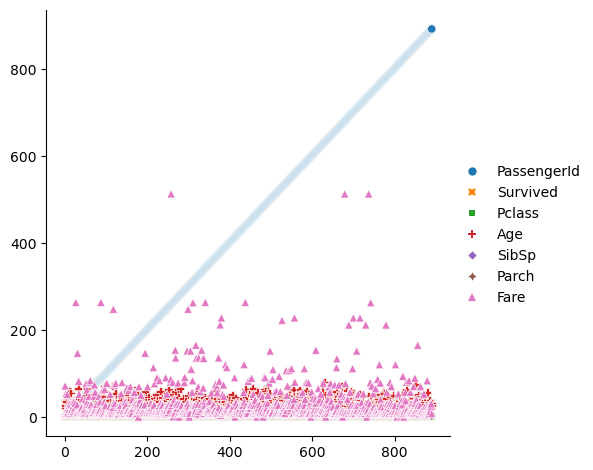

In [ ]:
sns.relplot(df_train)